In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
        

## Conv Block Module

In [2]:
class BasicBlock(nn.Module):
    """Basic Block for ResNet 18 and 34"""
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        # Shortcut connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Add the identity shortcut (x) to the output of conv layers (F(x))
        out += self.shortcut(identity)  # This is where H(x) = F(x) + x happens
        out = self.relu(out)
        
        return out

## Residual Block Module

In [3]:
class Bottleneck(nn.Module):
    """Bottleneck Block for ResNet 50, 101, 152"""
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        
        # Shortcut connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        out += self.shortcut(identity)
        out = self.relu(out)
        
        return out

## ResNet module 

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, in_channels=3):
        super(ResNet, self).__init__()
        
        self.in_channels = 64
        
        # Initial convolution
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        # Classification layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        
        # First block may have a different stride
        layers.append(block(self.in_channels, out_channels, stride))
        
        # Update in_channels for subsequent blocks
        self.in_channels = out_channels * block.expansion
        
        # Add the rest of the blocks
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

In [5]:
# Function to create different ResNet variants
def resnet18(num_classes=1000):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

def resnet34(num_classes=1000):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

def resnet50(num_classes=1000):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)

def resnet101(num_classes=1000):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes)

def resnet152(num_classes=1000):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes)

# Training a ResNet 34 on CIFAR-10 dataset

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Complete Training Module for ResNet-34 on CIFAR-10

This section provides a comprehensive training pipeline with proper data preprocessing, training loop, validation, and evaluation.


In [8]:
# Data preprocessing and augmentation
def get_cifar10_loaders(batch_size=128):
    """
    Get CIFAR-10 train and test data loaders with appropriate transforms
    """
    # Training transforms with data augmentation
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),  # Random crop with padding
        transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # CIFAR-10 normalization
    ])
    
    # Test transforms (no augmentation)
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    # Download and load datasets
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=test_transform
    )
    
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, test_loader


In [9]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        # Print progress
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, '
                  f'Loss: {loss.item():.4f}, '
                  f'Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


In [10]:
# Validation function
def validate(model, test_loader, criterion, device):
    """
    Validate the model
    """
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    
    return test_loss, test_acc


In [11]:
# Learning rate scheduler
def adjust_learning_rate(optimizer, epoch, initial_lr):
    """
    Adjust learning rate based on epoch (step decay)
    """
    if epoch >= 150:
        lr = initial_lr * 0.01  # Reduce by 100x after epoch 150
    elif epoch >= 100:
        lr = initial_lr * 0.1   # Reduce by 10x after epoch 100
    else:
        lr = initial_lr
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    return lr


In [12]:
# Complete training function
def train_resnet34_cifar10(epochs=200, batch_size=128, learning_rate=0.1):
    """
    Complete training pipeline for ResNet-34 on CIFAR-10
    """
    import time
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    # Get data loaders
    train_loader, test_loader = get_cifar10_loaders(batch_size)
    print(f'Training samples: {len(train_loader.dataset)}')
    print(f'Test samples: {len(test_loader.dataset)}')
    
    # Initialize model
    model = resnet34(num_classes=10)  # CIFAR-10 has 10 classes
    model = model.to(device)
    
    # Print model info
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total parameters: {total_params:,}')
    print(f'Trainable parameters: {trainable_params:,}')
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
    
    # Training history
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    learning_rates = []
    
    print('Starting training...')
    start_time = time.time()
    
    for epoch in range(epochs):
        # Adjust learning rate
        current_lr = adjust_learning_rate(optimizer, epoch, learning_rate)
        learning_rates.append(current_lr)
        
        print(f'\\nEpoch {epoch+1}/{epochs}, Learning Rate: {current_lr:.6f}')
        
        # Train for one epoch
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        test_loss, test_acc = validate(model, test_loader, criterion, device)
        
        # Store history
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        # Print epoch results
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        
        # Save checkpoint every 50 epochs
        if (epoch + 1) % 50 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'test_loss': test_loss,
                'test_acc': test_acc,
            }, f'resnet34_cifar10_epoch_{epoch+1}.pth')
            print(f'Checkpoint saved at epoch {epoch+1}')
    
    total_time = time.time() - start_time
    print(f'\\nTraining completed in {total_time/3600:.2f} hours')
    print(f'Best test accuracy: {max(test_accuracies):.2f}%')
    
    # Save final model
    torch.save(model.state_dict(), 'resnet34_cifar10_final.pth')
    
    return model, {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'learning_rates': learning_rates
    }


In [13]:
# Plotting function for training curves
def plot_training_curves(history):
    """
    Plot training curves
    """
    import matplotlib.pyplot as plt
    
    train_losses = history['train_losses']
    test_losses = history['test_losses']
    train_accuracies = history['train_accuracies']
    test_accuracies = history['test_accuracies']
    learning_rates = history['learning_rates']
    
    epochs = range(1, len(train_losses) + 1)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss curves
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, test_losses, 'r-', label='Test Loss')
    ax1.set_title('Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy curves
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, test_accuracies, 'r-', label='Test Accuracy')
    ax2.set_title('Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    # Learning rate schedule
    ax3.plot(epochs, learning_rates, 'g-')
    ax3.set_title('Learning Rate Schedule')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_yscale('log')
    ax3.grid(True)
    
    # Test accuracy zoomed
    ax4.plot(epochs, test_accuracies, 'r-', linewidth=2)
    ax4.set_title('Test Accuracy (Detailed)')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Test Accuracy (%)')
    ax4.grid(True)
    
    plt.tight_layout()
    plt.savefig('resnet34_training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()


In [14]:
# Class-wise accuracy analysis
def analyze_class_performance(model, test_loader, device):
    """
    Analyze per-class performance
    """
    # CIFAR-10 class names
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    model.eval()
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == target).squeeze()
            
            for i in range(target.size(0)):
                label = target[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    print("\\nPer-class accuracy:")
    for i in range(10):
        accuracy = 100 * class_correct[i] / class_total[i]
        print(f'{classes[i]}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
    
    return class_correct, class_total


In [16]:
# Main training execution
# Set random seeds for reproducibility
torch.manual_seed(42)
import numpy as np
np.random.seed(42)

# Train the model (uncomment to run full training)
print("Starting ResNet-34 training on CIFAR-10...")
print("Note: This will take several hours to complete. For quick testing, reduce epochs to 5-10.")

# For quick testing (5 epochs)
model, history = train_resnet34_cifar10(epochs=5, batch_size=128, learning_rate=0.1)

# For full training (uncomment the line below and comment the line above)
# model, history = train_resnet34_cifar10(epochs=200, batch_size=128, learning_rate=0.1)


Starting ResNet-34 training on CIFAR-10...
Note: This will take several hours to complete. For quick testing, reduce epochs to 5-10.
Using device: cpu
Files already downloaded and verified
Files already downloaded and verified
Training samples: 50000
Test samples: 10000
Total parameters: 21,289,802
Trainable parameters: 21,289,802
Starting training...
\nEpoch 1/5, Learning Rate: 0.100000
Batch 0/391, Loss: 2.7638, Acc: 7.03%
Batch 100/391, Loss: 2.7556, Acc: 12.47%
Batch 200/391, Loss: 2.2832, Acc: 14.74%
Batch 300/391, Loss: 2.0590, Acc: 16.65%
Train Loss: 2.5435, Train Acc: 18.32%
Test Loss: 2.1633, Test Acc: 23.55%
\nEpoch 2/5, Learning Rate: 0.100000
Batch 0/391, Loss: 2.0806, Acc: 25.00%
Batch 100/391, Loss: 1.8509, Acc: 25.87%
Batch 200/391, Loss: 1.8104, Acc: 27.44%
Batch 300/391, Loss: 1.7905, Acc: 28.76%
Train Loss: 1.8569, Train Acc: 29.68%
Test Loss: 1.6593, Test Acc: 36.83%
\nEpoch 3/5, Learning Rate: 0.100000
Batch 0/391, Loss: 1.7412, Acc: 34.38%
Batch 100/391, Loss: 1.67

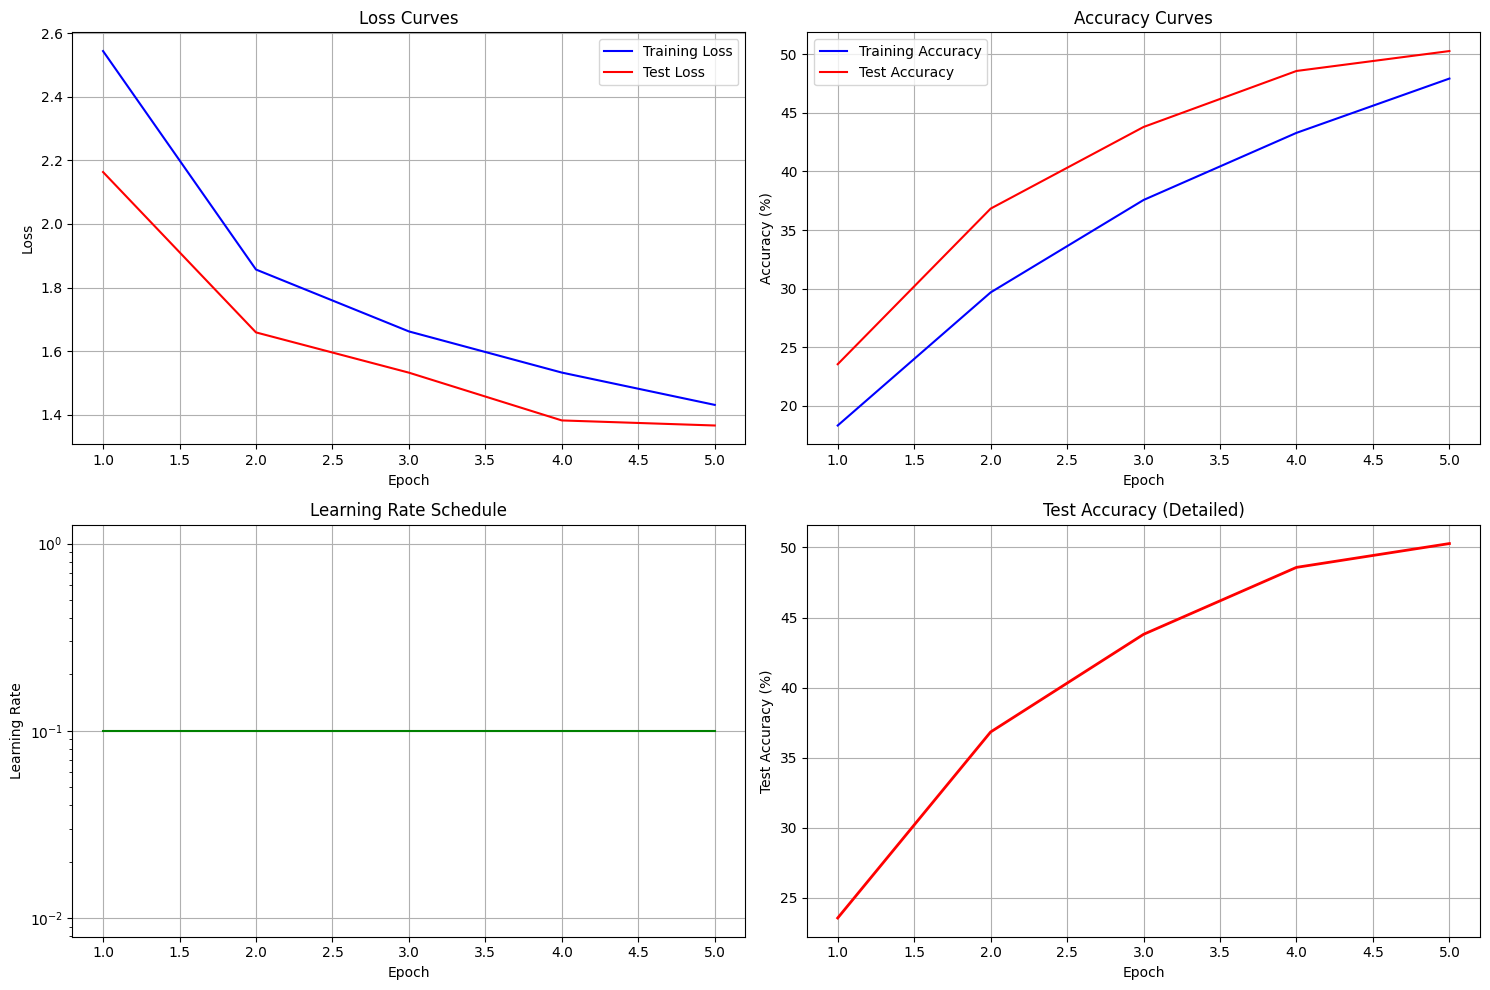

Files already downloaded and verified
Files already downloaded and verified
\nFinal model performance:
\nPer-class accuracy:
airplane: 48.40% (484/1000)
automobile: 60.70% (607/1000)
bird: 53.60% (536/1000)
cat: 11.30% (113/1000)
deer: 56.60% (566/1000)
dog: 48.30% (483/1000)
frog: 47.70% (477/1000)
horse: 59.90% (599/1000)
ship: 74.50% (745/1000)
truck: 41.80% (418/1000)


([484.0, 607.0, 536.0, 113.0, 566.0, 483.0, 477.0, 599.0, 745.0, 418.0],
 [1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0])

In [17]:
# Plot training curves
plot_training_curves(history)

# Analyze final model performance
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
_, test_loader = get_cifar10_loaders(batch_size=128)

print("\\nFinal model performance:")
analyze_class_performance(model, test_loader, device)


In [18]:
# Optional: Load and test a saved model
def load_and_test_model(model_path):
    """
    Load and test a saved model
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load model
    model = resnet34(num_classes=10)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    
    # Get test loader
    _, test_loader = get_cifar10_loaders(batch_size=128)
    
    # Test the model
    criterion = nn.CrossEntropyLoss()
    test_loss, test_acc = validate(model, test_loader, criterion, device)
    
    print(f'Loaded model test accuracy: {test_acc:.2f}%')
    
    # Analyze class-wise performance
    analyze_class_performance(model, test_loader, device)
    
    return model

# Example usage (uncomment to use):
# model = load_and_test_model('resnet34_cifar10_final.pth')
